# **Lab 4: Inversion of Time Domain Electromagnetic (TDEM) Sounding Data**
********

## **Table of Contents** 
 - [Lab purpose](#lab-purpose)
 - [Half-space model](#introduction-to-tdem-half-space-models)
 - [Part 1: Synthetic data](#part-1---synthetic-example)
  

## **Lab Purpose**

The objective is to learn about the EM field methods, focusing on EM data interpretation and inversion methods. In this lab, you will use a forward model for the TDEM response of a layered half space to invert TDEM data. The lab is seperated into two parts to help you learn how this forward model works. Part 1 will walk you through inversion of a synthetic dataset, then in Part 2, you will set up an inversion of a real dataset from [Sit' Tlein (Malaspina Glacier)](https://esrs.jsc.nasa.gov/Collections/EarthFromSpace/lores.pl?PHOTO=STS028-97-81) in southern Alaska.



<dl> 
<dt>Check List Before Getting Start: </dt> 

<dd> [ ] Download the .zip file from the course Canvas page </dd> 
<dd> [ ] Install Python and Jupyter Notebook either through Anaconda or VSCode following the instruction document on Canvas. </dd>
</dl>

---

## **Introduction to TDEM Half-Space Models** 

Analytic solutions can provide physical insights, serve as a basis for validation of numerical algorithms, reduce computational times, and expedite first-pass interpretation. In this lab, you will be using a half-space model to provide a simplified but useful analytical framework for interpreting TDEM data.

### What is half space?

In geophysics, a half-space refers to a theoretical model where the Earth is divided into two parts:

- The upper half, represents air or free space.
- The lower half, represents the ground, assumed to be uniform and infinite in depth.
  The lower half is characterized by a single electrical resistivity (or its inverse, conductivity) value.

### The Half-Space Model in TDEM

In a half-space model for TDEM:

- The ground is treated as a uniform, infinitely deep conductor.
- The transmitter is typically modeled as a vertical magnetic dipole at the surface.
- The receiver measures the vertical component of the secondary magnetic field.

For a half-space model, we can describe the late-time behavior of the vertical magnetic field (Hz) using **Equation 1** below:
$$H_z(t) = \frac{M}{4\pi\sigma\mu_0r^5} \cdot \frac{9}{20} \cdot \left(\frac{\mu_0\sigma r^2}{t}\right)^{5/2}$$

where $M$ is the transmitter moment, $\sigma$ is the conductivity of the half-space, $\mu_{0}$ is the magentic permeability of free space, $r$ is the transmitter-receiver speration, and $t$ is time after transmitter is turned off.

From Equation 1, we can see that in a half-space model, we assume the following:

- The field decays as $t^{-5/2}$ over time.
- The decay rate is indepedent of the half-space conductivity.
- The amplitude of the response is proportional to conductivity $\sigma^{3/2}$.

While the half-space model is useful for understanding basic TDEM principles, real-world geology is rarely this simple. In practice, we often need more sophisticated models that account for complex layered and dipping earth structures and lateral variations in conductivity.

---

## **Part 1 - Synthetic example**

To begin we will generate a synthetic EM dataset with a forward model, add some noise, and then try to invert to recover the starting earth model. You won't need to do any programming in this part - the goal is just to familiarize you with the tools in this notebook so that you can use them to invert the real dataset later in the notebook.


**Instruction:** _Make sure you update the working directory!_ 

In [1]:
import sys
import os

os.chdir("/Users/winniechu/Documents/Teaching/Geophysics/2024/lab/lab4-tdem-refraction")
sys.path.insert(0, os.getcwd())

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import walktem
import scipy

## (1a) Generate synthetic data

* First we will load a real data file to grab some parameters necessary for the forward model. Note that this is not strictly necessary, but it is quicker to do than making them up. 

In [3]:
# Load TDEM info
data = pd.read_csv(
    "geo4_tdem.txt",
    header=1,
)
t_obs = data["t"].to_numpy()

waveform = pd.read_csv(
    "tdem_waveform.txt",
    header=1,
)
waveform = {"t": waveform["t"].to_numpy(), "i": waveform["i"].to_numpy()}
loopsize = 40.0

* Next we make up some stratigraphy - in this case a three layered earth - and use a utiliy function we've provided to visualize the strat column. Our synthetic stratigraphy will be _a conductive layer sandwiched between two resistive ones_. There are many scenarios where this type of electro-stratigraphy might come up, for example an aquifer, or a sulfide mineral deposit.

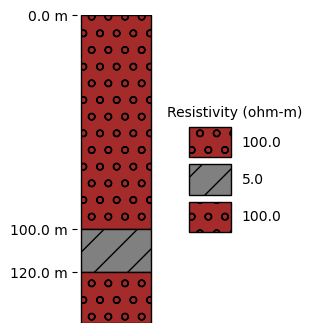

In [4]:
layer_thicknesses = [100, 20]  # Two thicknesses (bottom layer is assumed infinite)
layer_resistivities = [100, 5, 100]
walktem.strat_plot(
    layer_thicknesses, layer_resistivities, hatches=["o", "/"], colors=["brown", "grey"]
)

* Then we will use a forward model for the response of a TDEM instrument over a layered earth to generate a synthetic TDEM dataset.

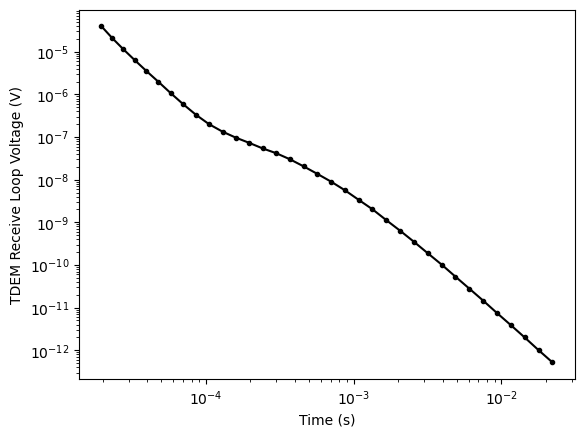

In [5]:
# Forward model
synth = walktem.walktem(
    layer_resistivities, np.cumsum(layer_thicknesses), t_obs, waveform, loopsize
)

# Add noise
synth += np.random.normal(loc=0, scale=synth * 0.01, size=len(synth))

# Make plot
plt.loglog(t_obs, synth, "k.-")
plt.xlabel("Time (s)")
plt.ylabel("TDEM Receive Loop Voltage (V)")
plt.show()

## (1b) Invert synthetic data

* In a inversion, we first need to define what a good fit to the synthetic data is. We will choose the L2 norm, $||data-model||^2_2$, scaled by the data value. The function `misfit_nlyr` implements this. 

* We will also need to pick a starting set of parameters for the inversion, `x0`. This is a very important input - just as important as the choice of misfit function. **Choosing a bad initial `x0` can make it impossible for your optimizer to find a good-fitting solution.** 

* For this synthetic example we know the correct solution, but with real data you never do and must often use other knowledge to come up with a good `x0` 
I'll recommend choosing something that generally represents the electro-stratigraphy (resistive, conductive, resistive) but is notable different from what we know to be the true model.

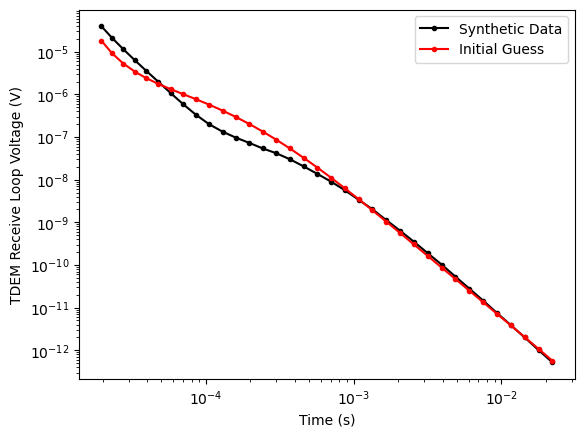

In [6]:
def misfit_nlyr(x, data, t_obs, waveform, loopsize):
    # Split x into resistivity and thickness
    nlyr = (len(x) + 1) // 2
    layer_resistivities = x[:nlyr]
    layer_thicknesses = x[nlyr:]
    model = walktem.walktem(
        layer_resistivities, np.cumsum(layer_thicknesses), t_obs, waveform, loopsize
    )
    return np.sum(np.power(data - model, 2) / ((0.1 * data) ** 2))


init_layer_resistivities = [150, 10, 75]
init_layer_thicknesses = [50, 30]

x0 = init_layer_resistivities + init_layer_thicknesses

# We also need to provide parameter bounds for the inversion, here I am constraining the resistivity to betweel 1 and 500 ohm meters
# and the layer thickness to between 0.5 and 200 meters
bounds = [(1, 500)] * 3 + [(0.5, 200)] * 2

# Forward model
x0_model = walktem.walktem(x0[:3], np.cumsum(x0[3:]), t_obs, waveform, loopsize)

# Make plot
plt.loglog(t_obs, synth, "k.-", label="Synthetic Data")
plt.loglog(t_obs, x0_model, "r.-", label="Initial Guess")
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("TDEM Receive Loop Voltage (V)")
plt.show()

* In this first guess above, we managed to replicate the general shape of the observed decay curve. However, they are still quite different! 
  
* Now we can run a _minimization algorithm_ to seek an earth model that better matches the observed data. The function call below implements this. Optimization (a.k.a. minimization) is a complex topic, worthy of class(es) in its own right. The next cell will take several tens of seconds to run.

In [7]:
# Run optimizer
res = scipy.optimize.minimize(
    misfit_nlyr,
    x0,
    method="nelder-mead",
    args=(synth, t_obs, waveform, loopsize),
    bounds=bounds,
    options={"fatol": 1e-10, "maxfev": len(x0) * 300},
)

print(res)

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.2848606392248728
             x: [ 1.001e+02  4.410e+00  9.938e+01  1.006e+02  1.739e+01]
           nit: 401
          nfev: 652
 final_simplex: (array([[ 1.001e+02,  4.410e+00, ...,  1.006e+02,
                         1.739e+01],
                       [ 1.001e+02,  4.410e+00, ...,  1.006e+02,
                         1.739e+01],
                       ...,
                       [ 1.001e+02,  4.410e+00, ...,  1.006e+02,
                         1.739e+01],
                       [ 1.001e+02,  4.410e+00, ...,  1.006e+02,
                         1.739e+01]]), array([ 2.849e-01,  2.849e-01,  2.849e-01,  2.849e-01,
                        2.849e-01,  2.849e-01]))


* You should see `message: Optimization terminated successfully.` if everything worked well so far. 
  
* **The message above is important.** In particular, the output vector `x` are the main results from the inversion, informing you the inverted layer resistivities and thickness parameters that best fit the observations. 

* We will plot these inversion results below to better visualize `x`. 

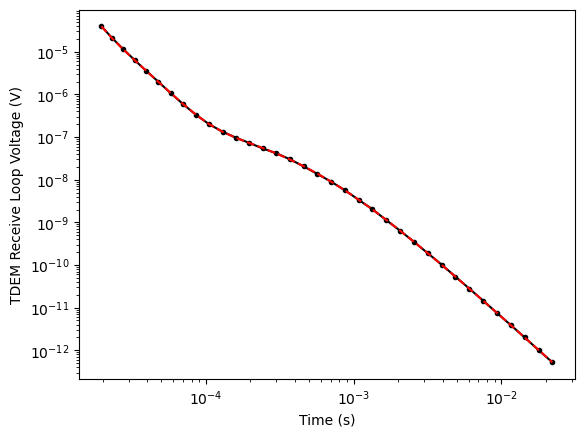

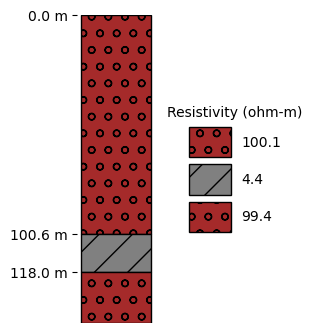

In [8]:
xinv = res.x
inv_layer_resistivities = xinv[:3]
inv_layer_thicknesses = xinv[3:]
inv = walktem.walktem(
    inv_layer_resistivities, np.cumsum(inv_layer_thicknesses), t_obs, waveform, loopsize
)

# Make plot
plt.loglog(t_obs, synth, "k.-")
plt.loglog(t_obs, inv, "r--")
plt.xlabel("Time (s)")
plt.ylabel("TDEM Receive Loop Voltage (V)")

# Resistivity column
walktem.strat_plot(
    inv_layer_thicknesses.tolist(),
    inv_layer_resistivities.tolist(),
    hatches=["o", "/", "o"],
    colors=["brown", "grey", "brown"],
    labels=["300 ohm-m", "1 ohm-m"],
)

* Great! From this exercise in Part 1, we've recovered our known original model. 

* Spend some time playing with this example. Change things like the initial guess `x0`, the misfit function, or the parameter bounds and see what happens. 
  
* Can you find an earth model that has a good fit to the data, but is very different from the true model?

* Now it is your turn to invert real data in Part 2! 

---

# Part 2 - Real data

We provide you with a code snippet below that loads a TDEM data file acquired on Sit' Tlein. **Invert for a two-layer earth model (ice above the subglacial material) and provide an estimate for the resistivity of the material below Sit' Tlein.** Note - your answer should be reasonable but there is not an exact value we are seeking, as your result will vary based on your initial model and optimizer parameters. Spend some time trying to manually find a starting model that is reasonably similar to the observed data - this will help the optimization routine converge on a model that fits well.

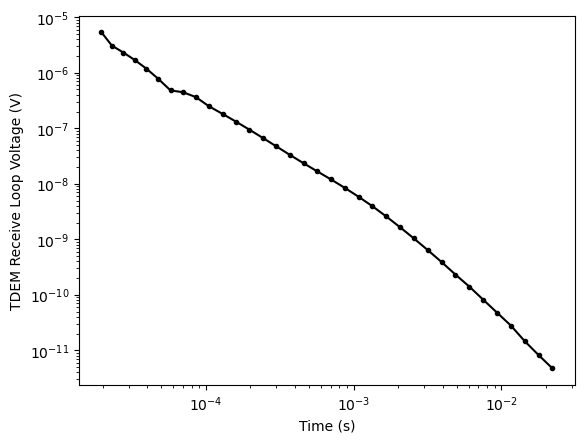

In [9]:
# Load TDEM data
data = pd.read_csv(
    "/Users/winniechu/Documents/Teaching/Geophysics/2024/lab/lab4-tdem-refraction/geo4_tdem.txt",
    header=1,
)
t_obs = data["t"].to_numpy()
v_obs = data["v"].to_numpy()

waveform = pd.read_csv(
    "/Users/winniechu/Documents/Teaching/Geophysics/2024/lab/lab4-tdem-refraction/tdem_waveform.txt",
    header=1,
)
waveform = {"t": waveform["t"].to_numpy(), "i": waveform["i"].to_numpy()}
loopsize = 40.0

# Plot
plt.loglog(t_obs, v_obs, "k.-")
plt.xlabel("Time (s)")
plt.ylabel("TDEM Receive Loop Voltage (V)")
plt.show()

* Now, let's perform the inversio by building a forward model for resistivities, just like what we did in Part 1 with the synthetic data. We will start with some initial guess for the different layer thickness and resisitvities ( `init_layer_resistivities` and  `init_layer_thickness`). 

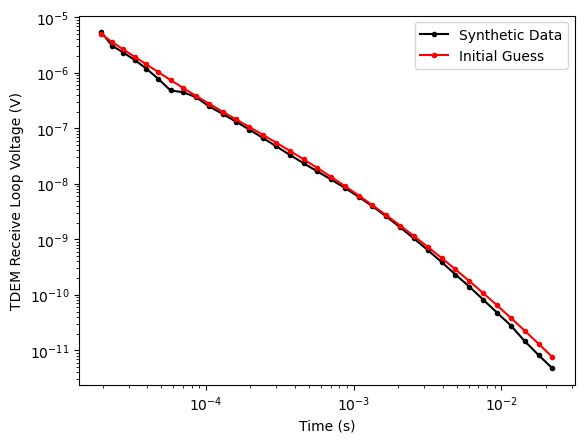

In [10]:
init_layer_resistivities = [575, 20, 8]
init_layer_thicknesses = [50, 30]

x0 = init_layer_resistivities + init_layer_thicknesses

# We also need to provide parameter bounds for the inversion, here I am constraining the resistivity to betweel 0.1 and 500 ohm meters
# and the layer thickness to between 0.5 and 200 meters
bounds = [(0.1, 10000)] * 3 + [(1, 200)] * 2

# Forward model
x0_model = walktem.walktem(x0[:3], np.cumsum(x0[3:]), t_obs, waveform, loopsize)

# Make plot
plt.loglog(t_obs, v_obs, "k.-", label="Synthetic Data")
plt.loglog(t_obs, x0_model, "r.-", label="Initial Guess")
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("TDEM Receive Loop Voltage (V)")
plt.show()

* Finally, we will run a _minimization algorithm_, let's see if the optimization procedure can get us closer to the observed data.

In [11]:
# Run optimizer
res = scipy.optimize.minimize(
    misfit_nlyr,
    x0,
    method="nelder-mead",
    args=(v_obs, t_obs, waveform, loopsize),
    bounds=bounds,
    options={"fatol": 1e-14, "maxfev": len(x0) * 400},
)

print(res)

       message: Maximum number of function evaluations has been exceeded.
       success: False
        status: 1
           fun: 27.979387442230614
             x: [ 1.000e+04  5.835e+01  1.033e+01  3.769e+01  3.226e+01]
           nit: 1253
          nfev: 2000
 final_simplex: (array([[ 1.000e+04,  5.835e+01, ...,  3.769e+01,
                         3.226e+01],
                       [ 1.000e+04,  5.835e+01, ...,  3.769e+01,
                         3.226e+01],
                       ...,
                       [ 1.000e+04,  5.835e+01, ...,  3.769e+01,
                         3.226e+01],
                       [ 1.000e+04,  5.835e+01, ...,  3.769e+01,
                         3.226e+01]]), array([ 2.798e+01,  2.798e+01,  2.798e+01,  2.798e+01,
                        2.798e+01,  2.798e+01]))



TDEM Model Inversion Results:
Layer 1: Resistivity = 10000.00 Ohm-m, Thickness = 37.69 m
Layer 2: Resistivity = 58.35 Ohm-m, Thickness = 32.26 m


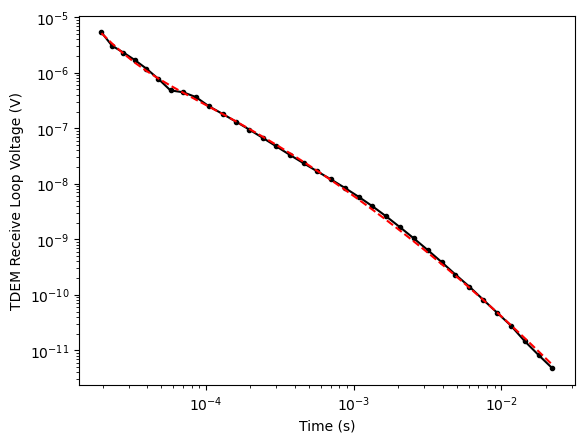

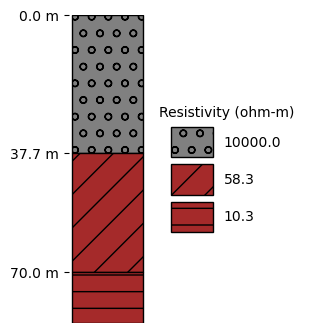

In [12]:
xinv = res.x
inv_layer_resistivities = xinv[:3]
inv_layer_thicknesses = xinv[3:]
inv = walktem.walktem(
    inv_layer_resistivities, np.cumsum(inv_layer_thicknesses), t_obs, waveform, loopsize
)

# Make plot
plt.loglog(t_obs, v_obs, "k.-")
plt.loglog(t_obs, inv, "r--")
plt.xlabel("Time (s)")
plt.ylabel("TDEM Receive Loop Voltage (V)")

# Resistivity column
walktem.strat_plot(
    inv_layer_thicknesses.tolist(),
    inv_layer_resistivities.tolist(),
    hatches=["o", "/", "-"],
    colors=["grey", "brown", "brown"],
    labels=["300 ohm-m", "1 ohm-m"],
)

print("\nTDEM Model Inversion Results:")
for i, (r, t) in enumerate(zip(inv_layer_resistivities, inv_layer_thicknesses)):
    print(f"Layer {i+1}: Resistivity = {r:.2f} Ohm-m, Thickness = {t:.2f} m")

In [13]:
# Define the number of layers in your model
n_layers = 3

# Extract inverted resistivities and thicknesses
inv_layer_resistivities = xinv[:n_layers]
inv_layer_thicknesses = xinv[n_layers:]

# Calculate depths from thicknesses
inv_depths = np.cumsum(inv_layer_thicknesses)

# Save the results
np.savez(
    "tdem_inversion_results.npz",
    resistivities=inv_layer_resistivities,
    thicknesses=inv_layer_thicknesses,
    depths=inv_depths,
    times=t_obs,
    observed_data=data,
)

print("Inversion results saved to tdem_inversion_results.npz")


Inversion results saved to tdem_inversion_results.npz
